# Predicting Medical Insurance

## Import data

In [1]:
from pathlib import Path
import pandas as pd
import subprocess

In [2]:
CSV_FILE = './insurance_dataset.csv'

if not Path(CSV_FILE).exists():
    subprocess.run(['bash', 'script.sh'])

df = pd.read_csv(CSV_FILE)

## EDA

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [5]:
df.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,NaN,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,NaN,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


In [6]:
df.shape

(1000000, 12)

In [7]:
df.describe()

,age,bmi,children,charges
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,41.495282,34.001839,2.499886,16735.117481
std,13.855189,9.231680,1.707679,4415.808211
min,18.000000,18.000000,0.000000,3445.011643
25%,29.000000,26.020000,1.000000,13600.372379
50%,41.000000,34.000000,2.000000,16622.127973
75%,53.000000,41.990000,4.000000,19781.465410
max,65.000000,50.000000,5.000000,32561.560374


In [8]:
df.dtypes

age                         int64
gender                     object
bmi                       float64
children                    int64
smoker                     object
region                     object
medical_history            object
family_medical_history     object
exercise_frequency         object
occupation                 object
coverage_level             object
charges                   float64
dtype: object

### Missing values

In [9]:
df.isna().sum()/df.shape[0]

age                       0.000000
gender                    0.000000
bmi                       0.000000
children                  0.000000
smoker                    0.000000
region                    0.000000
medical_history           0.250762
family_medical_history    0.250404
exercise_frequency        0.000000
occupation                0.000000
coverage_level            0.000000
charges                   0.000000
dtype: float64

In [10]:
def history_value_counts(c):
    return c.value_counts(normalize=True, dropna=False)

df[['medical_history', 'family_medical_history']].apply(lambda c: history_value_counts(c))

,medical_history,family_medical_history
NaN,0.250762,0.250404
Heart disease,0.250121,0.250035
High blood pressure,0.249782,0.249824
Diabetes,0.249335,0.249737


25% does not present medical history, therefore they are healthy which also means these will not be imputed.

In [226]:
df.fillna(
    {
        'medical_history':'Healthy', 
        'family_medical_history':'Healthy'}, 
    inplace=True)

### Numerical features

In [11]:
df.drop('charges', axis=1).select_dtypes([int, float]).columns.tolist()

['age', 'bmi', 'children']

In [12]:
NUMERICAL_FEATURES = ['age', 'bmi', 'children']

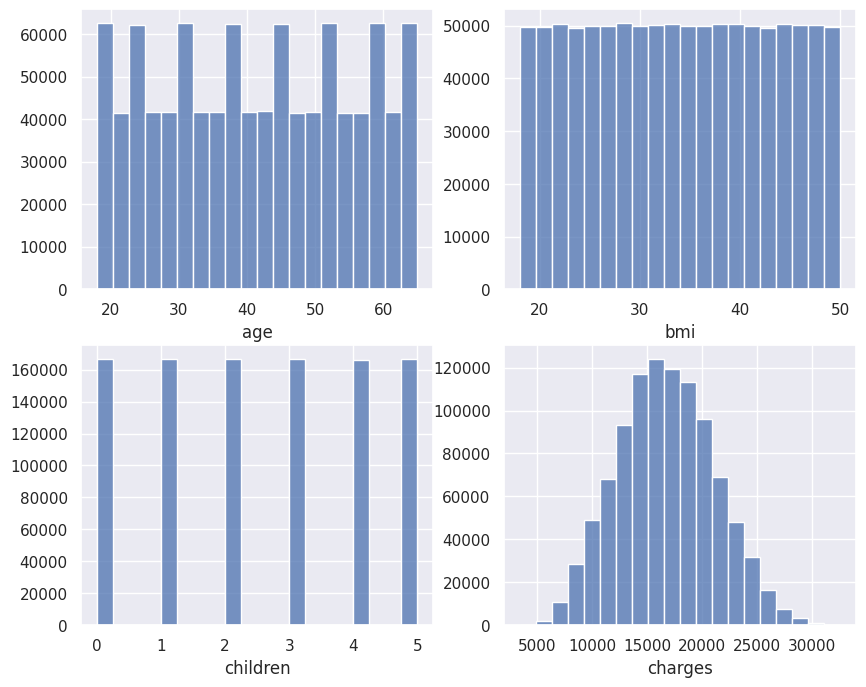

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for col, ax in zip(NUMERICAL_FEATURES+['charges'], axs.flatten()):
    sns.histplot(df[col], bins=20, ax=ax)
    ax.set_ylabel(None)

According the charts: `age`, `bmi` and `childres` have uniform distrubution whereas charges has a normal distribution. So there is no need to make any transformation onto numerical features.

### Categorical features

In [14]:
df.select_dtypes(object).columns.tolist()

['gender',
 'smoker',
 'region',
 'medical_history',
 'family_medical_history',
 'exercise_frequency',
 'occupation',
 'coverage_level']

In [15]:
CATEGORICAL_FEATURES = ['gender',
                        'smoker',
                        'region',
                        'medical_history',
                        'family_medical_history',
                        'exercise_frequency',
                        'occupation',
                        'coverage_level']

In [227]:
from IPython.display import display

for c in CATEGORICAL_FEATURES:
    df_valuecounts = pd.DataFrame(df[c].value_counts(normalize=True))
    display(df_valuecounts)

,proportion
gender,
male,0.500107
female,0.499893


,proportion
smoker,
yes,0.500129
no,0.499871


,proportion
region,
northeast,0.250343
southwest,0.250095
northwest,0.249931
southeast,0.249631


,proportion
medical_history,
Healthy,0.250762
Heart disease,0.250121
High blood pressure,0.249782
Diabetes,0.249335


,proportion
family_medical_history,
Healthy,0.250404
Heart disease,0.250035
High blood pressure,0.249824
Diabetes,0.249737


,proportion
exercise_frequency,
Rarely,0.250538
Occasionally,0.250362
Frequently,0.249746
Never,0.249354


,proportion
occupation,
Unemployed,0.250571
Student,0.250279
Blue collar,0.249825
White collar,0.249325


,proportion
coverage_level,
Basic,0.333515
Standard,0.333508
Premium,0.332977


All categorical features have perfectly proportioned classes

### Correlations

/home/erick/.cache/pypoetry/virtualenvs/medical-insurance-prediction-ml-o21d09mz-py3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


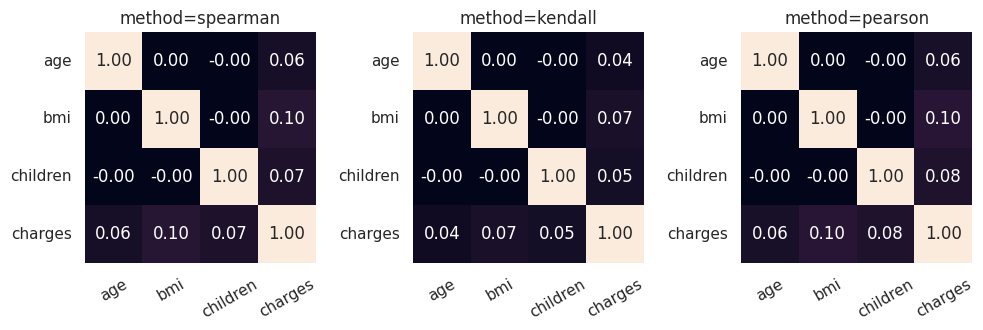

In [219]:
fix, axs = plt.subplots(1, 3, figsize=(12, 3))
axs = axs.flatten()
methods = ['spearman', 'kendall', 'pearson']

for method, ax in zip(methods, axs):
    sns.heatmap(df[NUMERICAL_FEATURES+['charges']].corr(method=method), annot=True, fmt='.2f', ax=ax, cbar=False, square=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_title(f'method={method}')

The numerical features are completely independent each other for different correlation methods (*Spearman*, *Kendall* and *Pearson*)

#### (Age, Bmi, Children) intervals vs charges

In [224]:
print('Age:', df.age.min(), df.age.max())
print('Bmi:', df.bmi.min(), df.bmi.max())
print('children:', df.children.min(), df.children.max())

Age: 18 65
Bmi: 18.0 50.0
children: 0 5


In [36]:
def get_groups(values: list, column:str):
    charges_mean = []

    for i, value in enumerate(values[:-1]):
        lower_value, upper_value = value, values[i+1]
        
        charges_by_group = df[
            (df[column]>lower_value) & (df[column]<=upper_value)
            ].charges.mean()
        
        charges_mean.append((f'{lower_value}-{upper_value}', charges_by_group))
    
    return pd.DataFrame(charges_mean, columns=[f'{column}_interval', 'mean_charges'])
    

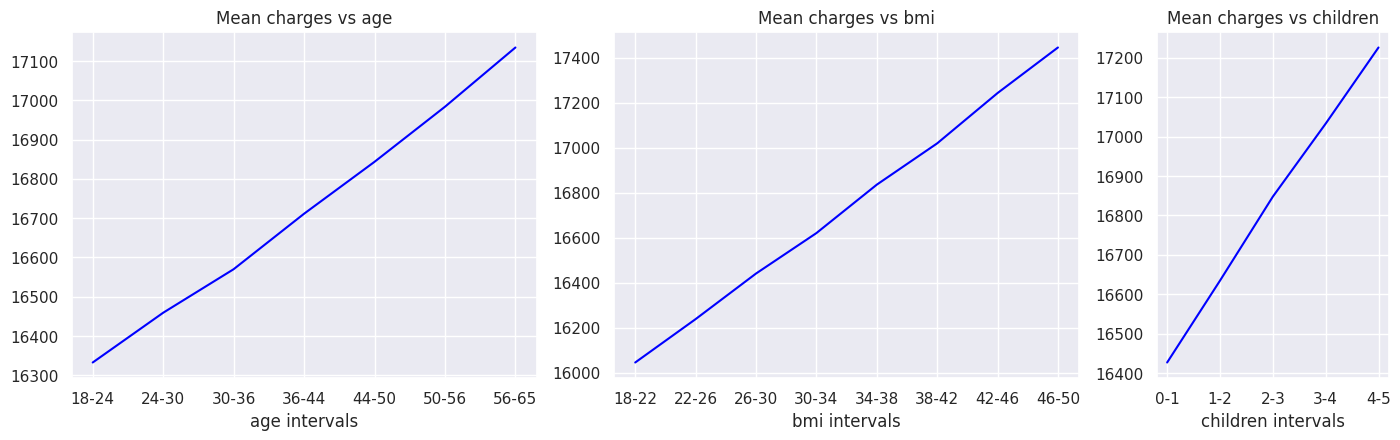

In [39]:
dict_intervals = {
    'age': [18, 24, 30, 36, 44, 50, 56, 65], 
    'bmi': [18, 22, 26, 30, 34, 38, 42, 46, 50],
    'children': [0, 1, 2, 3, 4, 5]
}

fix, axs = plt.subplots(1, 3, figsize=(17, 4.5), width_ratios=[.4, .4, .2])
axs = axs.flatten()

for (feature, intervals), ax in zip(dict_intervals.items(), axs):
    df_charges_mean = get_groups(intervals, feature)

    sns.lineplot(df_charges_mean, x=f'{feature}_interval', y='mean_charges', ax=ax, c='blue')
    ax.set_title(f'Mean charges vs {feature}')
    ax.set_xlabel(f'{feature} intervals')
    ax.set_ylabel(None)

# Just in case to create suplots with dimensions (2, 2)
# and in order to not see an empty chart in the last subplot, uncommment thi next line to null it:
#axs[-1].axis('off')

Hidden correlations were discovered between the `age`, `bmi` and `children` features, and the target column, just by splitting them into intervals and calculating the mean of charges for each group.  
The more age, BMI or children a person has, the more expensive the medical insurance will be. As a result, it provides a signal of how these might affect the charges.

### Distributions

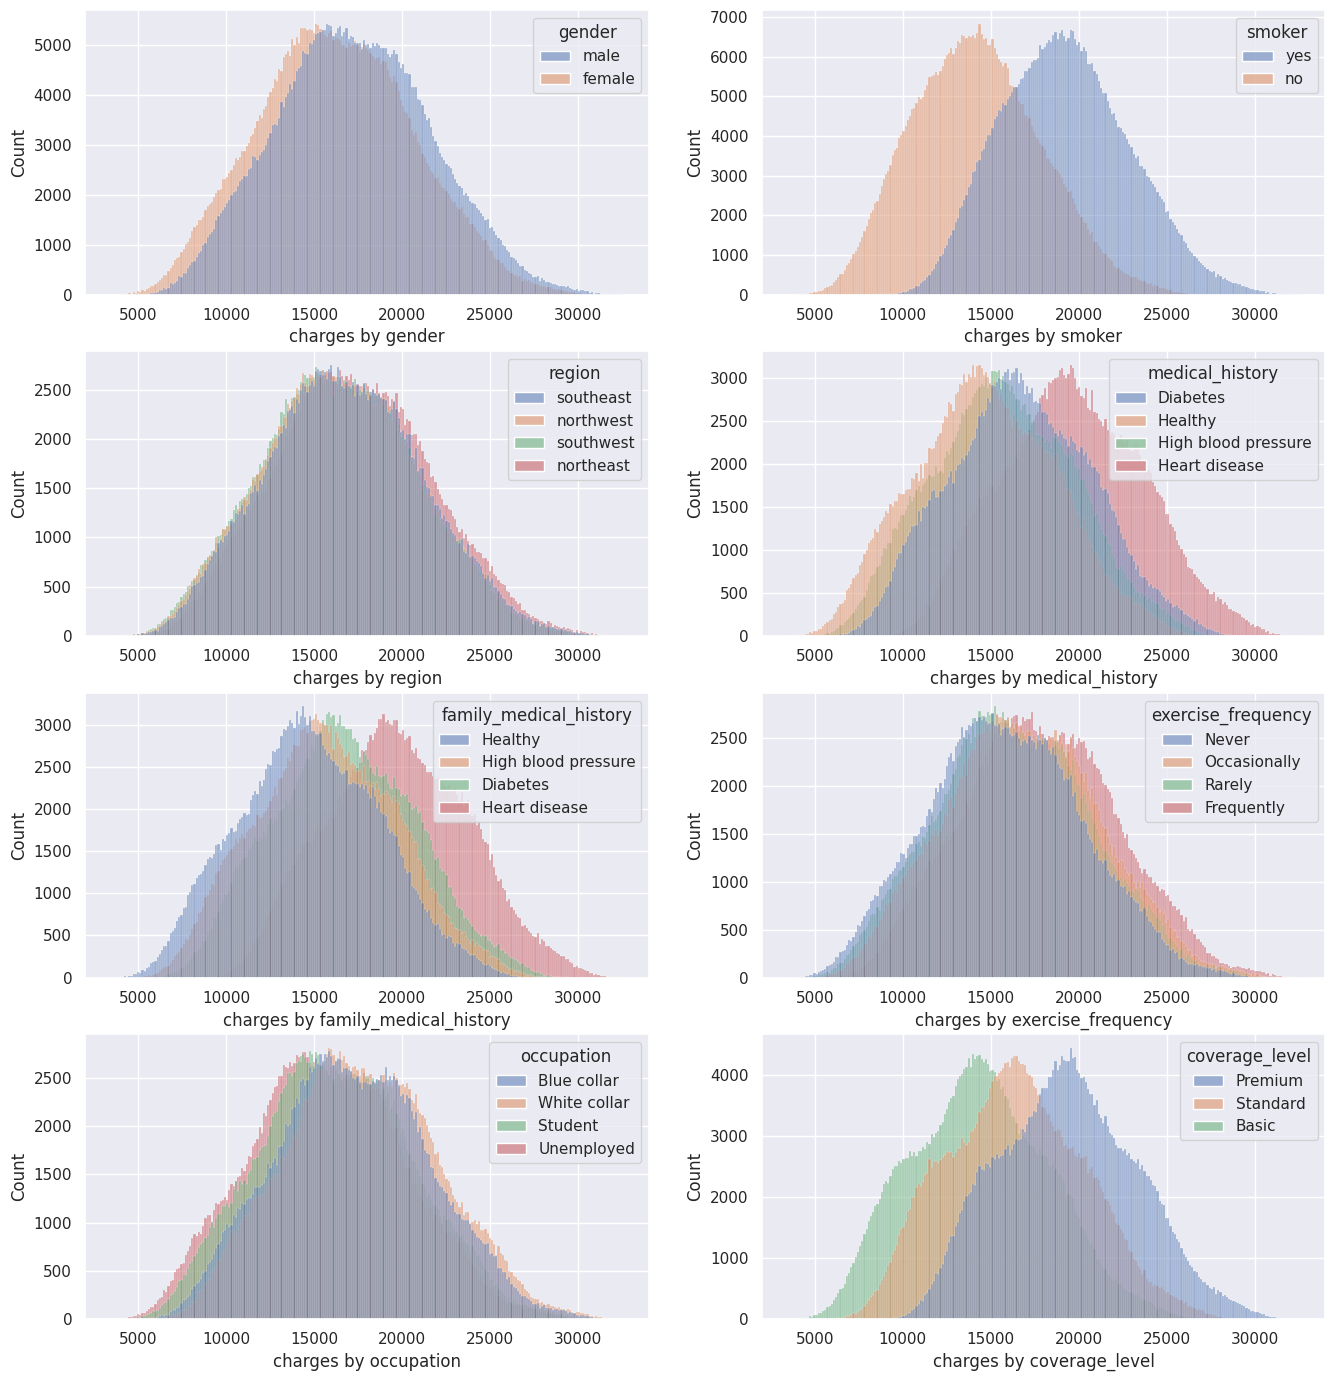

In [230]:
fig, axs = plt.subplots(4, 2, figsize=(16, 17))
axs = axs.flatten()
for c, ax in zip(CATEGORICAL_FEATURES, axs):
    sns.histplot(df, x='charges', hue=c, ax=ax)
    ax.set_xlabel(f'charges by {c}')

There is a uniform distribution between the charges in each category class, so it confirms there is no presence of outliers.

## Training

### Baseline: Dummy model

In [4]:
df.coverage_level.value_counts()

coverage_level
Basic       333515
Standard    333508
Premium     332977
Name: count, dtype: int64

Let's apply OneHotEncoding to categorical features, except for `coverage_level` since this latter looks like an ordinal category, so I will consider using OrdinalEncoding.

In [46]:
from sklearn.dummy import DummyRegressor
from feature_engine.encoding import OneHotEncoder, OrdinalEncoder
from feature_engine.imputation import CategoricalImputer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [28]:
df_full_train, df_test = train_test_split(df, test_size=.2, random_state=10)
df_train, df_val = train_test_split(df_full_train, test_size=.25)

In [30]:
y_train = df_train.charges.values
df_train.drop('charges', axis=1, inplace=True)

y_val = df_val.charges.values
df_val.drop('charges', axis=1, inplace=True)

y_test = df_test.charges.values
df_test.drop('charges', axis=1, inplace=True)

In [262]:
# NUMERICAL_FEATURES = ['age', 'bmi', 'children']
OHE_FEATURES = ['gender',
                'smoker',
                'region',
                'medical_history',
                'family_medical_history',
                'exercise_frequency',
                'occupation'
]
ORDINAL_ENCODER_FEATURES = ['coverage_level']
CATEGORICAL_IMPUTER_FEATURES = ['medical_history', 'family_medical_history']

pipeline = Pipeline(steps=[
    ('categorical imputer', CategoricalImputer(fill_value='Healthy', variables=CATEGORICAL_IMPUTER_FEATURES)),
    ('ordinal encoder', OrdinalEncoder(variables=ORDINAL_ENCODER_FEATURES, ignore_format=True)),
    ('ohe', OneHotEncoder(variables=OHE_FEATURES, ignore_format=True)),
    ('dummy regressor', DummyRegressor())
])

pipeline.fit(df_train, y_train)


Pipeline(steps=[('categorical imputer',
                 CategoricalImputer(fill_value='Healthy',
                                    variables=['medical_history',
                                               'family_medical_history'])),
                ('ordinal encoder',
                 OrdinalEncoder(ignore_format=True,
                                variables=['coverage_level'])),
                ('ohe',
                 OneHotEncoder(ignore_format=True,
                               variables=['gender', 'smoker', 'region',
                                          'medical_history',
                                          'family_medical_history',
                                          'exercise_frequency',
                                          'occupation'])),
                ('dummy regressor', DummyRegressor())])

In [330]:
def evaluate(model: Pipeline, X_train: pd.DataFrame, X_val: pd.DataFrame, y_train: list, y_val: list):
    sns.set()
    
    y_pred_train = model.predict(X_train) 
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    
    y_pred = model.predict(X_val) 
    rmse_val = mean_squared_error(y_val, y_pred, squared=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
    
    suptitle = f'''model={model[-1].__class__()}
    {rmse_train=:.3f}
    {rmse_val=:.3f}'''
    fig.suptitle(suptitle, fontsize=11)
    
    sns.histplot(y_val - y_pred, label='Validation errors', ax=ax1, bins=50)
    sns.histplot(y_train - y_pred_train, label='Training errors', ax=ax1, bins=50, zorder=0)
    ax1.legend()
    
    ax1.set_xlabel('Error distributions')
    
    sns.scatterplot(x=y_val, y=y_pred, ax=ax2)
    lims = [
        min(ax2.get_xlim(), ax2.get_ylim()),
        max(ax2.get_xlim(), ax2.get_ylim())
    ]
    ax2.plot(lims, lims, 'k-', zorder=0, lw=3)
    ax2.set_xlabel('y_val')
    ax2.set_ylabel('y_pred')

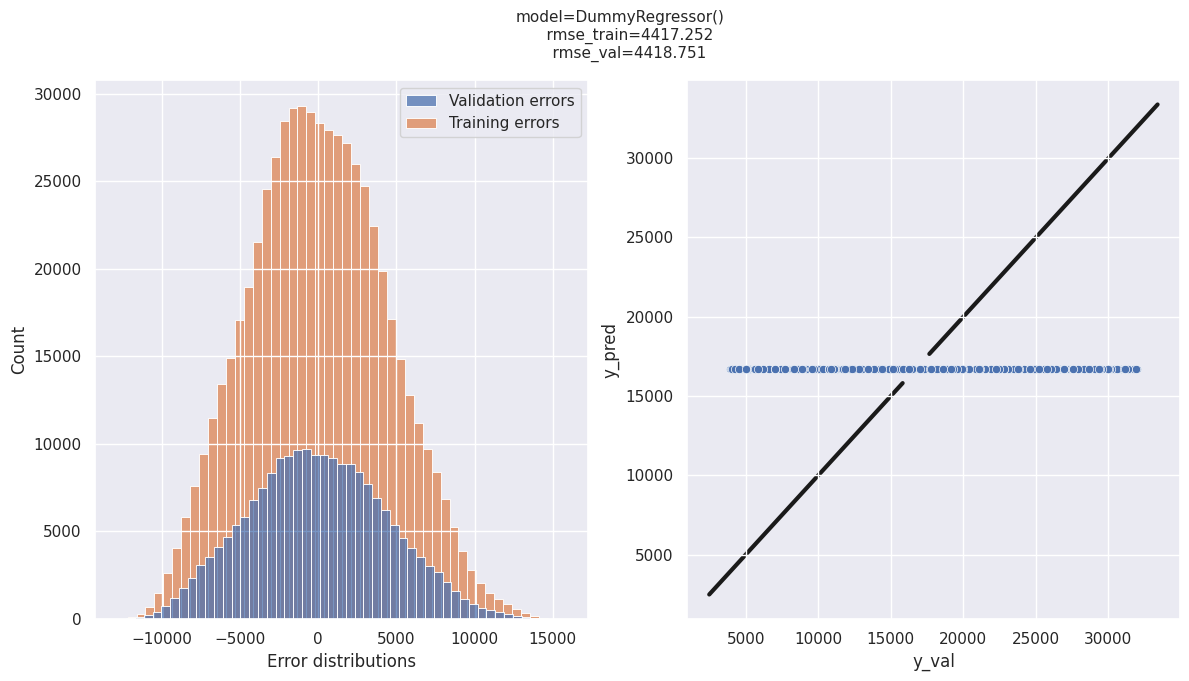

In [331]:
evaluate(pipeline, df_train, df_val, y_train, y_val)

### 